In [1]:
import findspark
from datetime import datetime
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import pandas as pd
import requests
from time import gmtime, strftime
from datetime import datetime
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import date_format
from pyspark.sql.functions import lit
%matplotlib inline 

In [2]:
bitcoins = ['#bitcoin', '#ethereum', '#ripple','#bitcoin-cash','#eos','#litecoin', '#cardano', '#stellar', '#iota', '#tron']

In [3]:
# Can only run this once. restart your kernel for any errors.
sc = SparkContext()

ssc = StreamingContext(sc, 60)
sqlContext = SQLContext(sc)

socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

lines = socket_stream.window( 120 )

In [4]:
from collections import namedtuple
fields = ("tag", "count")
Tweet = namedtuple( 'Tweet', fields )


In [5]:
def get_price(coin1):
    '''
    Call API for getting the coin price.
    coin: 
    '''
    url1 = "https://api.coinmarketcap.com/v1/ticker/"
    prices1= {}
    response1=requests.get(url1)
    
    for i in range(10):
        prices1[response1.json()[i]["id"]] = float(response1.json()[i]["price_usd"])
        
    return  prices1[coin1[1:]]
                

get_coin_value = udf(get_price, FloatType())    





def get_percent_change_1h(coin2):
    url2 = "https://api.coinmarketcap.com/v1/ticker/"
    '''
    Call API for getting the coin percent_change_1h.
    coin: 
    '''
    prices2= {}
    response2=requests.get(url2)
    
    for i in range(10):
        prices2[response2.json()[i]["id"]] = float(response2.json()[i]["percent_change_1h"])
        
    return  prices2[coin2[1:]]
               

get_coin_change_1h = udf(get_percent_change_1h, FloatType())  




def get_market_cap_usd(coin3):
 '''
    Call API for getting the coin market_cap_usd.
    coin: 
    '''
    url3 = "https://api.coinmarketcap.com/v1/ticker/"
    prices3= {}
    response3=requests.get(url3)
    
    for i in range(10):
        prices3[response3.json()[i]["id"]] = float(response3.json()[i]["market_cap_usd"])
        
    return  prices3[coin3[1:]]
                

get_coin_market_cap_usd = udf(get_market_cap_usd, FloatType()) 


In [6]:
(lines.flatMap( lambda text: text.split( " " ) ) # Splits to a list
    .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
    .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word # Checks for hashtag calls
    .filter( lambda word:word[0] in bitcoins )# Filter in the list
    .reduceByKey( lambda a, b: a + b ) # Reduces
    .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
    .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )# Sorts Them in a DF
    .select('tag','count', # Call the coinmarketapi to get the values
            get_coin_value('tag').alias('Price'),
            get_coin_change_1h('tag').alias('Percent_change_1h'),
            get_coin_market_cap_usd('tag').alias('Market_cap_usd'))
    .withColumn('Time',lit(str(strftime("%H:%M", time.localtime()))))# Create a new column with the local time 
    .limit(50).registerTempTable("tweets") ) ) # Registers to a table tweets.


In [7]:
schema= StructType([
    StructField("tag", StringType(), True),
    StructField("count", IntegerType(), True),
    StructField("Price", FloatType(), True),
    StructField("Percent_change_1h", FloatType(), True),
    StructField("Market_cap_usd", FloatType(), True),
    StructField("Time", StringType(), True)  
    ])



TotalDateFrame = sqlContext.createDataFrame(sc.emptyRDD(), schema)

In [8]:
TotalDateFrame.printSchema()

root
 |-- tag: string (nullable = true)
 |-- count: integer (nullable = true)
 |-- Price: float (nullable = true)
 |-- Percent_change_1h: float (nullable = true)
 |-- Market_cap_usd: float (nullable = true)
 |-- Time: string (nullable = true)



# Run the  TweetRead.py from terminal

In [9]:
ssc.start()

In [10]:

count = 0
flag = 1

query_time = []
time_stamps = []

while count < 300:
    
    time.sleep(61)
    
    start_time = time.time()
    
    Window_results = sqlContext.sql( 'Select * from tweets')
    print(Window_results.count())
    
    
    
    print(Window_results.show())
    print('--')
   
    #TotalDateFrame= TotalDateFrame.union(Window_results)
   
    if flag ==1:
        
        total = Window_results.toPandas()
        flag =0
    else: 
        
        wind = Window_results.toPandas()
        total = pd.concat([total,wind])
        

    print("--- %s seconds ---" % round(time.time() - start_time,2))   
    
    query_time.append(round(time.time() - start_time,2))
    time_stamps.append(strftime("%H:%M", time.localtime()))
    
    print('----------') 
    count = count + 1  

3
+---------+-----+-------+-----------------+--------------+-----+
|      tag|count|  Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+-------+-----------------+--------------+-----+
|#ethereum|    2|599.445|             0.78|   5.986705E10|00:02|
|     #eos|    1|13.7783|             0.35| 1.23474166E10|00:02|
| #bitcoin|    1|7554.32|             0.46| 1.28990962E11|00:02|
+---------+-----+-------+-----------------+--------------+-----+

None
--
--- 6.54 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
|#ethereum|   28|  599.445|             0.78|   5.986705E10|00:04|
| #bitcoin|   24|  7554.32|             0.46| 1.28990962E11|00:04|
|    #tron|   12|0.0595857|             0.78|  3.91764736E9|00:04|
|     #eos|   10|  13.7783|             0.35| 1.23474166E10|00:04|
|  #ripple|    3| 0.674121|    

--- 2.78 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   52|  7553.83|              0.3| 1.28982589E11|00:13|
|#ethereum|   15|   597.48|             0.15|  5.9670807E10|00:13|
|    #tron|    8|0.0596717|             0.82|  3.92330163E9|00:13|
|     #eos|    3|  13.7703|             0.17| 1.23402476E10|00:13|
|  #ripple|    2| 0.670042|             0.32| 2.62934712E10|00:13|
|    #iota|    2|  1.73295|            -0.16|   4.8167869E9|00:13|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.85 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   55|  7553.83|              0.3| 1.2898

--- 2.08 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   15|  7534.64|            -0.08| 1.28655671E11|00:24|
|    #tron|    9|0.0594638|             0.31|  3.90963251E9|00:24|
|#ethereum|    8|  595.945|            -0.23|  5.9517682E10|00:24|
|  #ripple|    3| 0.666191|            -0.67| 2.61423514E10|00:24|
|     #eos|    1|  13.6592|            -0.69| 1.22406851E10|00:24|
|#litecoin|    1|  119.802|            -0.05|   6.8088535E9|00:24|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.19 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   21|  7530.87|            -0.14| 1.2859

--- 5.23 seconds ---
----------
9
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   35| 7522.74|            -0.32| 1.28452477E11|00:36|
|    #tron|   17|0.059402|            -0.02|  3.90556928E9|00:36|
|#ethereum|    7| 595.095|            -0.47|  5.9432788E10|00:36|
|  #ripple|    6|0.668518|            -0.97| 2.62336655E10|00:36|
| #stellar|    5|0.294209|             0.04|   5.4663322E9|00:36|
|     #eos|    3| 13.6789|            -0.61| 1.22583388E10|00:36|
| #cardano|    2|0.214973|            -0.57|   5.5736202E9|00:36|
|    #iota|    2| 1.72915|            -0.73|   4.8062249E9|00:36|
|#litecoin|    2| 119.629|            -0.29|   6.7990211E9|00:36|
+---------+-----+--------+-----------------+--------------+-----+

None
--
--- 5.62 seconds ---
----------
9
+---------+-----+--------+-----------------+--------------+-----+

--- 1.99 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   43|  7514.94|            -0.48| 1.28319291E11|00:47|
|    #tron|   10|0.0595412|            -0.08|  3.91472154E9|00:47|
|#ethereum|    5|  594.518|            -0.66|   5.937535E10|00:47|
|  #ripple|    3| 0.668555|            -1.28| 2.62351176E10|00:47|
|     #eos|    3|  13.6883|            -0.59| 1.22667633E10|00:47|
|#litecoin|    3|   119.58|            -0.35|   6.7962634E9|00:47|
|    #iota|    1|  1.72813|            -0.96|   4.8033894E9|00:47|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 4.87 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+-------

--- 1.52 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   39|  7521.48|            -0.41| 1.28430965E11|00:59|
|    #tron|    8|0.0596533|            -0.01|  3.92209178E9|00:59|
|#ethereum|    8|  594.374|            -0.72|  5.9360969E10|00:59|
|  #ripple|    5| 0.668921|            -1.15| 2.62494802E10|00:59|
|     #eos|    3|  13.7164|            -0.44| 1.22919444E10|00:59|
| #cardano|    1| 0.215027|            -0.79|     5.57502E9|00:59|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.51 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   45|  7521.48|            -0.41| 1.2843

--- 2.32 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   35|  7525.31|            -0.26| 1.28496927E11|01:11|
|    #tron|   13|0.0593033|             -0.4|  3.89907994E9|01:11|
|#ethereum|   11|  593.653|            -0.63|    5.92891E10|01:11|
|     #eos|    4|  13.6051|            -1.02| 1.21922038E10|01:11|
|  #ripple|    3| 0.662614|            -1.21| 2.60019835E10|01:11|
|    #iota|    1|   1.7231|            -0.57|   4.7894088E9|01:11|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.78 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   32|  7525.31|            -0.26| 1.2849

--- 2.19 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   42|  7508.55|            -0.36| 1.28210747E11|01:22|
|    #tron|   20|0.0590502|            -0.71|  3.88243917E9|01:22|
|#ethereum|   14|  592.271|            -0.69|  5.9151241E10|01:22|
|  #ripple|    6| 0.659964|             -1.3| 2.58979942E10|01:22|
|#litecoin|    3|  119.337|            -0.39|   6.7825121E9|01:22|
|     #eos|    2|  13.5296|            -1.18|  1.2124544E10|01:22|
| #stellar|    2| 0.291684|            -0.97|   5.4194232E9|01:22|
| #cardano|    1| 0.213947|            -0.91|   5.5470188E9|01:22|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 6.24 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_

--- 2.54 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   35|  7493.88|            -0.43| 1.27960252E11|01:34|
|#ethereum|    8|  590.833|            -0.75|  5.9007623E10|01:34|
|    #tron|    7|0.0592042|            -0.43|  3.89256422E9|01:34|
|     #eos|    6|  13.5226|            -1.14|  1.2118271E10|01:34|
|  #ripple|    3| 0.658887|            -1.31| 2.58557317E10|01:34|
| #stellar|    1| 0.292285|            -0.48|   5.4305894E9|01:34|
|#litecoin|    1|  119.476|            -0.13|   6.7904123E9|01:34|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.98 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+-------

--- 2.87 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   28|  7488.14|            -0.44| 1.27862514E11|01:46|
|#ethereum|   14|  589.452|            -0.87|  5.8869854E10|01:46|
|    #tron|   11|0.0590058|            -0.83|     3.87952E9|01:46|
|  #ripple|    3| 0.659111|            -1.41| 2.58645217E10|01:46|
| #stellar|    1| 0.292336|            -0.34|   5.4315387E9|01:46|
|#litecoin|    1|  119.417|            -0.15|   6.7870771E9|01:46|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.18 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   31|  7488.14|            -0.44| 1.2786

--- 1.84 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   19|  7499.48|             -0.3| 1.28056148E11|01:57|
|    #tron|   12|0.0592063|            -0.49|  3.89270246E9|01:57|
|#ethereum|   11|   592.44|             -0.3|  5.9168272E10|01:57|
|  #ripple|    3| 0.662599|            -0.76| 2.60013957E10|01:57|
|     #eos|    2|   13.555|            -0.95| 1.21473065E10|01:57|
|#litecoin|    2|  119.753|             0.14|   6.8061737E9|01:57|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.81 seconds ---
----------
5
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   21|  7499.48|             -0.3| 1.2805

--- 2.08 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   23|   7500.9|            -0.24| 1.28080495E11|02:09|
|    #tron|   11|0.0592197|            -0.27|  3.89358336E9|02:09|
|#ethereum|    8|  593.406|            -0.03|  5.9264922E10|02:09|
|     #eos|    6|  13.5822|            -0.41| 1.21716818E10|02:09|
|  #ripple|    3| 0.661898|            -0.45|  2.5973887E10|02:09|
|#litecoin|    2|  119.896|             0.36|   6.8143247E9|02:09|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.95 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   22|   7500.9|            -0.24| 1.2808

--- 2.54 seconds ---
----------
6
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   60| 7518.49|              0.1| 1.28380846E11|02:21|
|    #tron|   11| 0.05951|             0.51|  3.91267021E9|02:21|
|#ethereum|    9| 594.981|             0.49|  5.9422372E10|02:21|
|     #eos|    5| 13.6247|             0.62| 1.22097684E10|02:21|
|  #ripple|    1|0.662538|             0.18| 2.59990016E10|02:21|
| #stellar|    1|0.292275|             0.01|   5.4304901E9|02:21|
+---------+-----+--------+-----------------+--------------+-----+

None
--
--- 1.85 seconds ---
----------
5
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   43| 7518.49|              0.1| 1.28380846E11|02:22|

--- 2.43 seconds ---
----------
8
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   35| 7515.98|             0.25| 1.28337986E11|02:33|
|    #tron|   11|  0.0593|             0.27|   3.8988631E9|02:33|
|#ethereum|   10| 595.044|             0.76|  5.9428663E10|02:33|
|  #ripple|    4|0.661612|             0.43| 2.59626639E10|02:33|
|     #eos|    4| 13.5997|              0.6| 1.21873644E10|02:33|
| #stellar|    1|0.292172|             0.08|   5.4285763E9|02:33|
|#litecoin|    1| 119.832|             0.37|   6.8107172E9|02:33|
|    #iota|    1| 1.73452|             1.43|   4.8211507E9|02:33|
+---------+-----+--------+-----------------+--------------+-----+

None
--
--- 2.6 seconds ---
----------
6
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|


--- 15.13 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   34|  7507.61|             0.17| 1.28195723E11|02:45|
|#ethereum|    7|  594.073|             0.58|  5.9331854E10|02:45|
|     #eos|    4|  13.5615|             0.33|  1.2153131E10|02:45|
| #cardano|    3|  0.21405|             0.22|   5.5496893E9|02:45|
|    #iota|    3|  1.73224|             1.17|   4.8148137E9|02:45|
|    #tron|    2|0.0591776|             0.08|  3.89081549E9|02:45|
|  #ripple|    2|  0.66047|             0.12| 2.59178496E10|02:45|
| #stellar|    1| 0.292218|             0.02|   5.4294323E9|02:45|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 5.13 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market

--- 2.34 seconds ---
----------
7
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   17| 7506.67|             0.11| 1.28179667E11|02:58|
|    #tron|    8|0.059197|             0.06|  3.89209088E9|02:58|
|#ethereum|    6| 594.686|             0.47|  5.9393073E10|02:58|
|  #ripple|    4|0.661084|             0.03| 2.59419443E10|02:58|
|     #eos|    2| 13.5516|             0.07| 1.21442591E10|02:58|
|#litecoin|    2| 119.591|            -0.07|   6.7970468E9|02:58|
|    #iota|    2| 1.73109|             0.53|   4.8116173E9|02:58|
+---------+-----+--------+-----------------+--------------+-----+

None
--
--- 2.49 seconds ---
----------
7
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+

--- 1.86 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   35|  7511.33|             0.06| 1.28259432E11|03:09|
|#ethereum|   13|  595.182|              0.3|  5.9442758E10|03:09|
|    #tron|    6|0.0591471|            -0.17|  3.88881024E9|03:09|
|  #ripple|    3| 0.662283|            -0.02| 2.59889951E10|03:09|
|     #eos|    3|  13.5522|            -0.19| 1.21447967E10|03:09|
| #cardano|    1| 0.214298|            -0.11|   5.5561196E9|03:09|
|#litecoin|    1|  119.568|             -0.2|   6.7957699E9|03:09|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 1.91 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+-------

--- 2.35 seconds ---
----------
3
+---------+-----+-------+-----------------+--------------+-----+
|      tag|count|  Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+-------+-----------------+--------------+-----+
| #bitcoin|   31|7521.83|             0.13| 1.28439009E11|03:20|
|#ethereum|    6|597.251|             0.46|  5.9649577E10|03:20|
|    #tron|    3|0.05941|             0.06|  3.90609536E9|03:20|
+---------+-----+-------+-----------------+--------------+-----+

None
--
--- 1.19 seconds ---
----------
5
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   35| 7521.83|             0.13| 1.28439009E11|03:21|
|#ethereum|   11| 597.251|             0.46|  5.9649577E10|03:21|
|  #ripple|    3|0.663746|             0.16| 2.60464067E10|03:21|
|    #tron|    2| 0.05941|             0.06|  3.90609536E9|03:21|
|    #

--- 2.46 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   43|  7507.43|            -0.07| 1.28193118E11|03:33|
|    #tron|   19|0.0593749|             0.06|  3.90378752E9|03:33|
|#ethereum|   18|  596.688|             0.33|  5.9593351E10|03:33|
|  #ripple|    6| 0.664044|             0.39| 2.60581007E10|03:33|
|     #eos|    3|  13.6174|              0.1| 1.22032261E10|03:33|
|#litecoin|    3|   119.93|             0.22|   6.8163651E9|03:33|
|    #iota|    1|  1.73156|            -0.06|   4.8129234E9|03:33|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.21 seconds ---
----------
7
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+-------

--- 2.6 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   38|  7508.71|            -0.02| 1.28215253E11|03:43|
|#ethereum|   14|  596.881|             0.38|  5.9612803E10|03:43|
|    #tron|    7|0.0592164|            -0.06|  3.89336653E9|03:43|
|  #ripple|    2| 0.663887|              0.4| 2.60519383E10|03:43|
|     #eos|    2|  13.6256|             0.36| 1.22105743E10|03:43|
| #cardano|    1| 0.214281|            -0.09|   5.5556787E9|03:43|
|    #iota|    1|  1.72684|            -0.33|   4.7998039E9|03:43|
| #stellar|    1| 0.292047|            -0.11|   5.4262595E9|03:43|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.15 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_c

--- 1.38 seconds ---
----------
6
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   34|  7490.88|            -0.22| 1.27910797E11|03:55|
|    #tron|   15|0.0591076|            -0.11|  3.88621312E9|03:55|
|#ethereum|   10|  595.184|              0.1|  5.9443319E10|03:55|
|     #eos|    6|  13.5734|             0.11|  1.2163796E10|03:55|
|  #ripple|    3| 0.663367|             0.34| 2.60315341E10|03:55|
|#litecoin|    1|  119.769|              0.2|   6.8072356E9|03:55|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.07 seconds ---
----------
5
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   27|  7498.12|            -0.12| 1.2803

--- 2.55 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   32|  7498.99|            -0.13|  1.2804966E11|04:07|
|    #tron|   12|0.0591031|            -0.13|  3.88591718E9|04:07|
|#ethereum|   10|  596.049|             0.01|  5.9529875E10|04:07|
|  #ripple|    6| 0.660435|            -0.33| 2.59164774E10|04:07|
|     #eos|    4|  13.5836|             0.03| 1.21729362E10|04:07|
|    #iota|    4|  1.73024|            -0.25|   4.8092544E9|04:07|
| #stellar|    3|   0.2917|            -0.19|   5.4198139E9|04:07|
| #cardano|    1| 0.213762|            -0.36|   5.5422223E9|04:07|
|#litecoin|    1|  119.838|             0.18|    6.811199E9|04:07|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.63 seconds ---
----------
6
+---------+-----+---------+-----------------+-------

--- 1.73 seconds ---
----------
7
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+
| #bitcoin|   46| 7502.96|            -0.13| 1.28117449E11|04:18|
|#ethereum|   13| 593.237|            -0.57|  5.9249029E10|04:18|
|    #tron|   13|0.058818|            -0.82|  3.86717235E9|04:18|
|  #ripple|    5|0.656668|            -1.04| 2.57686548E10|04:18|
|     #eos|    3| 13.4921|            -0.85| 1.20909384E10|04:18|
|#litecoin|    3| 119.033|            -0.58|   6.7654456E9|04:18|
| #cardano|    2|0.212973|            -0.79|   5.5217659E9|04:18|
+---------+-----+--------+-----------------+--------------+-----+

None
--
--- 1.89 seconds ---
----------
7
+---------+-----+--------+-----------------+--------------+-----+
|      tag|count|   Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+--------+-----------------+--------------+-----+

--- 2.07 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   70|  7447.72|            -0.85| 1.27174476E11|04:31|
|#ethereum|   29|  585.925|            -1.85|  5.8518925E10|04:31|
|    #tron|   10|0.0584552|            -1.54|  3.84331904E9|04:31|
|  #ripple|    5|  0.65005|            -2.12| 2.55089541E10|04:31|
|#litecoin|    3|  118.015|            -1.56|   6.7076214E9|04:31|
|     #eos|    2|  13.3035|            -2.32| 1.19219251E10|04:31|
| #cardano|    1| 0.209103|            -2.41|   5.4214282E9|04:31|
| #stellar|    1| 0.289399|            -0.85|   5.3770624E9|04:31|
|    #iota|    1|  1.69807|            -1.87|   4.7198372E9|04:31|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.7 seconds ---
----------
9
+---------+-----+---------+-----------------+--------

--- 1.77 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   36|  7440.93|            -0.88| 1.27058903E11|04:42|
|#ethereum|   13|  585.973|            -1.72|  5.8523922E10|04:42|
|    #tron|   11|0.0584024|            -1.49|  3.83984742E9|04:42|
|  #ripple|    4| 0.650685|            -1.95| 2.55338721E10|04:42|
|     #eos|    4|  13.2714|            -2.42| 1.18931579E10|04:42|
| #stellar|    2| 0.288895|            -1.03|      5.3677E9|04:42|
|    #iota|    1|  1.70349|            -1.21|   4.7349023E9|04:42|
|#litecoin|    1|  117.918|            -1.64|   6.7021404E9|04:42|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 5.72 seconds ---
----------
5
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_

--- 2.27 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   32|  7452.07|            -0.65| 1.27249129E11|04:54|
|#ethereum|   22|  585.239|            -1.77|  5.8450612E10|04:54|
|    #tron|    8|0.0581732|            -1.67|  3.82477798E9|04:54|
|#litecoin|    6|    117.7|            -1.84|     6.68975E9|04:54|
|     #eos|    3|  13.2085|            -2.76| 1.18367908E10|04:54|
| #cardano|    2| 0.207948|            -2.66|   5.3914824E9|04:54|
|    #iota|    2|  1.69093|             -1.9|    4.699991E9|04:54|
|  #ripple|    1| 0.646405|            -2.46| 2.53659177E10|04:54|
| #stellar|    1| 0.288464|            -1.15|   5.3596918E9|04:54|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.69 seconds ---
----------
8
+---------+-----+---------+-----------------+-------

--- 1.32 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   35|  7423.51|            -1.01| 1.26761533E11|05:06|
|    #tron|   19|0.0579393|            -1.85|  3.80939955E9|05:06|
|#ethereum|   11|  582.064|            -2.03|  5.8133676E10|05:06|
|  #ripple|    4| 0.642249|            -2.78| 2.52028314E10|05:06|
|     #eos|    4|  13.1311|            -2.95| 1.17674281E10|05:06|
| #cardano|    1| 0.206027|            -3.32|   5.3416765E9|05:06|
|    #iota|    1|  1.67518|            -2.64|   4.6562135E9|05:06|
| #stellar|    1| 0.286184|            -1.78|   5.3173315E9|05:06|
|#litecoin|    1|  117.268|            -2.01|    6.665217E9|05:06|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.51 seconds ---
----------
9
+---------+-----+---------+-----------------+-------

--- 1.83 seconds ---
----------
8
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_cap_usd| Time|
+---------+-----+---------+-----------------+--------------+-----+
| #bitcoin|   47|   7407.6|            -1.15| 1.26489862E11|05:16|
|#ethereum|   21|  582.969|            -1.43|  5.8224062E10|05:16|
|    #tron|   15|0.0577268|            -1.85|   3.7954281E9|05:16|
|     #eos|    7|  13.1951|            -2.18| 1.18247823E10|05:16|
| #stellar|    5| 0.285989|            -1.56|   5.3137085E9|05:16|
|  #ripple|    4| 0.644599|            -1.61| 2.52950487E10|05:16|
|    #iota|    1|  1.67841|            -2.05|   4.6651914E9|05:16|
|#litecoin|    1|  117.412|            -1.25|   6.6734013E9|05:16|
+---------+-----+---------+-----------------+--------------+-----+

None
--
--- 2.64 seconds ---
----------
9
+---------+-----+---------+-----------------+--------------+-----+
|      tag|count|    Price|Percent_change_1h|Market_

# Plot Benchmarks

Text(0,0.5,'execution time')

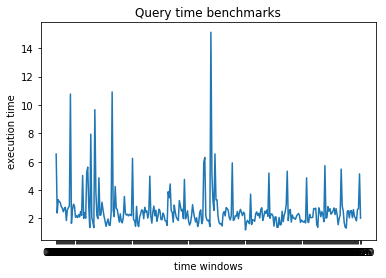

In [22]:
plt.title('Query time benchmarks')

plt.plot(time_stamps, query_time)

plt.xlabel('time windows')
plt.ylabel('Execution time')

In [32]:
d = {'time':time_stamps,
     'query time':query_time    
}

qr = pd.DataFrame(d)

In [33]:
qr.head()

,query time,time
0,6.54,00:03
1,2.38,00:04
2,3.32,00:05
3,3.19,00:06
4,3.12,00:07


<Figure size 864x1080 with 0 Axes>

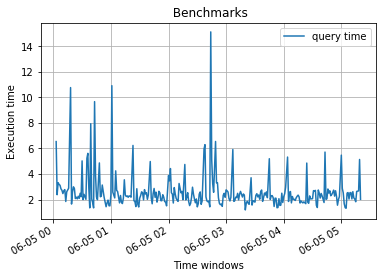

In [34]:
qr['time'] = pd.to_datetime(qr['time'] )

plt.figure( figsize = ( 12, 15 ) )

ax = qr.plot(x='time', y='query time',grid = True,title =" Benchmarks")
ax.set_xlabel("Time windows")
ax.set_ylabel("Execution time")

ax.figure.savefig('query_time.png')

In [11]:
total.shape

(2119, 6)

In [12]:
file_name= 'Final_5h.csv'
total.to_csv(file_name,index=False)

# Plot all bitcoins and save them


In [ ]:
total = pd.read_csv('Final_5h.csv')

In [17]:
def plot_coin(total,coin):
    
    name = coin[1:].capitalize()
    try:
        total['Time'] = pd.to_datetime(total['Time'] )
        print('%%%%%%%%%%%%%%%%%% '+name+' %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        plt.figure( figsize = ( 12, 15 ) )
        #plot count of tweets
        ax = total[total['tag']== coin].plot(x='Time', y='count',grid = True,title = name)
        ax.set_ylabel("Count")

        name_plot1 = name+'_count.png'
        ax.figure.savefig('plots/'+name_plot1)

        #plot the Price of bitcoin
        ax1=total[total['tag']== coin].plot(x='Time', y='Price',grid = True,title = name)
        ax1.set_ylabel("Price")

        name_plot2 = name+'_price.png'
        ax1.figure.savefig('plots/'+name_plot2)

        plt.show()
    except:
        return


%%%%%%%%%%%%%%%%%% Bitcoin %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

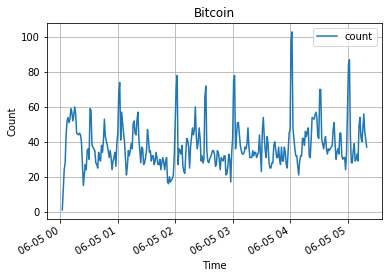

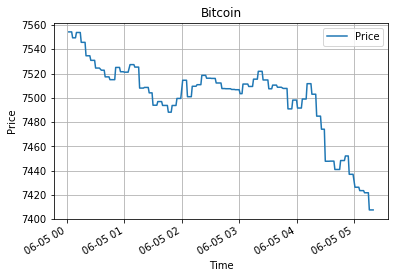

%%%%%%%%%%%%%%%%%% Ethereum %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

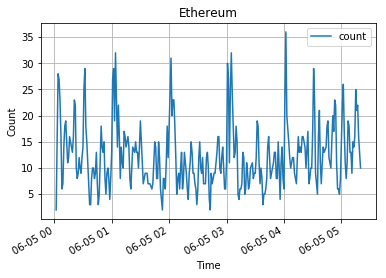

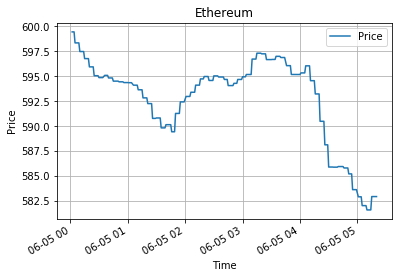

%%%%%%%%%%%%%%%%%% Ripple %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

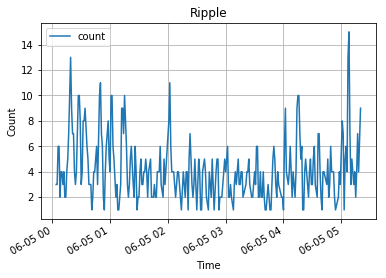

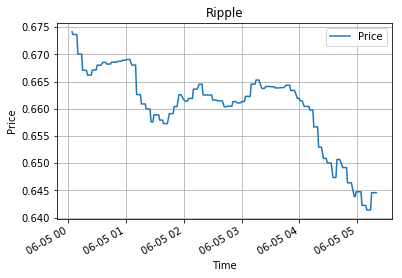

%%%%%%%%%%%%%%%%%% Bitcoin-cash %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%% Eos %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

<Figure size 864x1080 with 0 Axes>

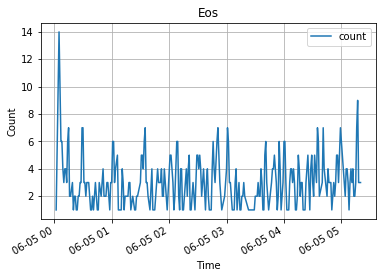

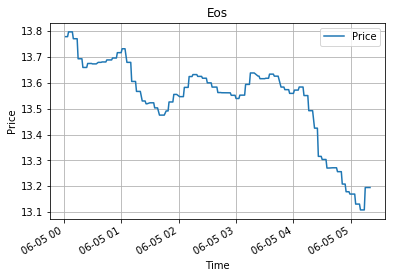

%%%%%%%%%%%%%%%%%% Litecoin %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

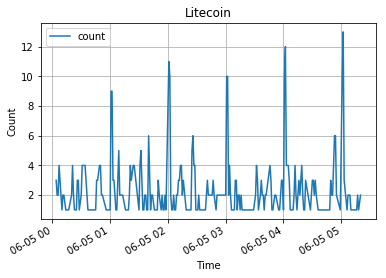

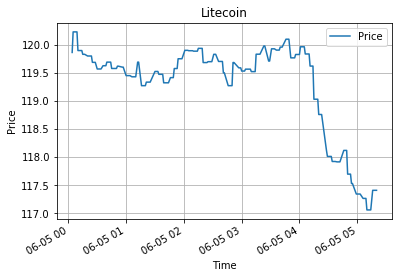

%%%%%%%%%%%%%%%%%% Cardano %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

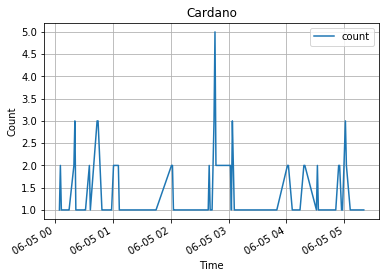

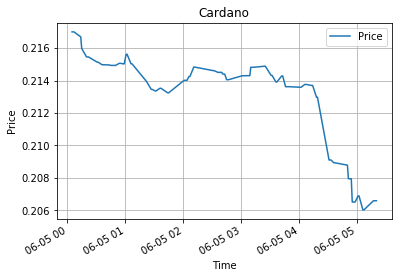

%%%%%%%%%%%%%%%%%% Stellar %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

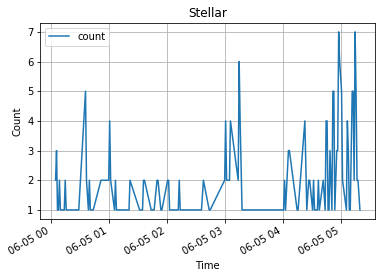

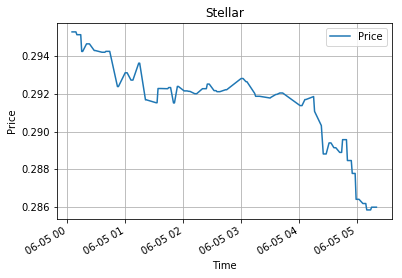

%%%%%%%%%%%%%%%%%% Iota %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

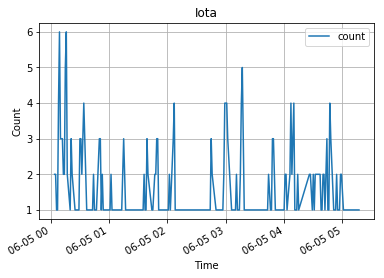

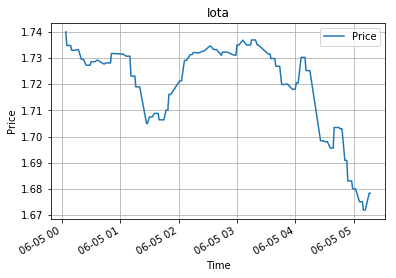

%%%%%%%%%%%%%%%%%% Tron %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


<Figure size 864x1080 with 0 Axes>

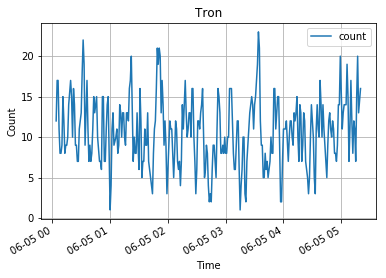

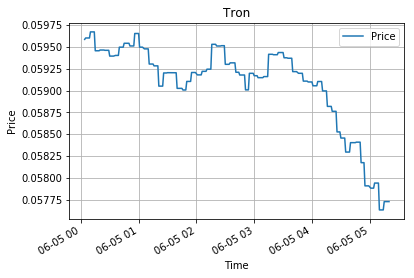

In [18]:
for i in bitcoins:

    plot_coin(total,i)

In [ ]:
ssc.stop()